#examples vs accuracy
Vlute$_\infty$ [(1, 15.496), (2, 26.745), (3, 30.041), (4, 35.501), (5, 40.303), (6, 42.967), (7, 45.897), (8, 48.94), (9, 49.59)]
Vlute$_{1000}$ [(1, 27.742), (2, 35.132), (3, 41.277), (4, 44.171), (5, 47.175), (6, 48.286), (7, 50.586), (8, 52.532), (9, 53.747)]
Vlute$_{10000}$ [(1, 33.425), (2, 41.959), (3, 44.393), (4, 47.798), (5, 54.136), (6, 54.41), (7, 56.458), (8, 59.297), (9, 61.962)]
Vlute$_{B\infty}$ [(1, 16.135), (2, 24.223), (3, 30.692), (4, 33.978), (5, 36.75), (6, 38.534), (7, 40.504), (8, 43.168), (9, 44.731)]
Vlute$_{B1000}$ [(1, 25.479), (2, 32.434), (3, 37.611), (4, 40.773), (5, 42.865), (6, 43.381), (7, 45.018), (8, 46.938), (9, 47.6)]
Vlute$_{B10000}$ [(1, 27.51), (2, 33.959), (3, 39.148), (4, 42.824), (5, 44.496), (6, 47.695), (7, 50.234), (8, 51.119), (9, 53.337)]
Brute [(1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)]


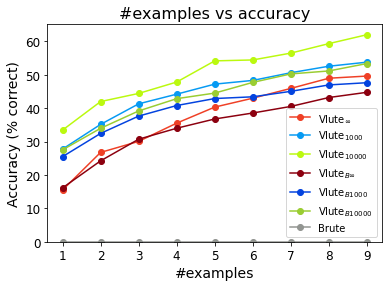

In [2]:
import json
import os
from collections import Callable
import matplotlib.pyplot as plt

class Results:
    def __init__(self, data, colors):
        self.results = [Result(d["file"], d["name"], colors[d["name"]]) for d in data]

    def filter_fields(self, fields: list[str]):
        for r in self.results:
            r.filter_fields(fields)

    def aggregate(self, over: str):
        for r in self.results:
            r.aggregate(over)

    def filter(self, field: str, cond: Callable[[object], bool]):
        for r in self.results:
            r.filter(field, cond)

    def filter_all(self, id_field: str, field: str, cond: Callable[[object], bool]):

        d = {}
        for r in self.results:
            for e in r.results:
                if e[id_field] not in d:
                    d[e[id_field]] = []

                if cond(Result._field_parser(e, field)):
                    d[e[id_field]].append(e)

        l = len(self.results)
        for i in range(0, l):
            self.results[i].results = [v[i] for k, v in d.items() if len(v) == l]

    def plot(self, x: Callable, y: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.plot(x, y, ax)

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.title(title, fontsize=16)
        plt.legend()

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.scatter_plot(x, y, label, ax)

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)
        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.title(title, fontsize=16)

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        for r in self.results:
            r.histogram(x, bins)

    def save(self, question: int, domain: str, name: str):
        folder = "{}/Q{}/graphs/{}".format(os.getcwd(), question, domain)

        if not os.path.exists(folder):
            os.makedirs(folder)

        plt.savefig("{}/{}.pdf".format(folder, name), bbox_inches='tight')

class Result:
    def __init__(self, file_name, name, color):
        self.name = name
        self.color = color

        self.results = []

        with open(file_name, "r") as file:
            for line in file:
                stripped_line = line.strip()
                obj = json.JSONDecoder().decode(stripped_line)
                self.results.append(obj)

    def filter_fields(self, fields: list[str]):
        for i, res in enumerate(self.results):
            self.results[i] = {f: self._field_parser(res, f) for f in fields}

    @staticmethod
    def _field_parser(obj, field):
        if field == "complexity":
            return int(obj["file"].split("/")[1].split("-")[0])

        if field == "file_tuple":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[0]), int(a[1]), int(a[2])

        if field == "correct":
            return 1 if obj["test_cost"] == obj["train_cost"] == 0 else 0

        if field == "zero_train_cost":
            return 1 if obj["train_cost"] == 0 else 0

        if field == "overfitted":
            return 1 if obj["test_cost"] > 0 and obj["train_cost"] == 0 else 0

        if field == "explored_per_sec":
            return obj["number_of_explored_programs"] / obj["execution_time"]

        if field == "average_explored_size_tokens":
            a = obj["explored_per_size_tokens"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field == "average_explored_size_sequence":
            a = obj["explored_per_size_sequence"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field in obj:
            return obj[field]

        raise Exception()

    def aggregate(self, over: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def filter(self, field: str, cond: Callable[[object], bool]):
        result = []

        for res in self.results:
            if cond(self._field_parser(res, field)):
                result.append(res)

        self.results = result

    def plot(self, x: Callable, y: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs)))

        ax.plot(
            xs, ys,
            label=self.name,
            marker='o',
            color=self.color,
        )

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        xrs =  [x.__round__(5) for x in xs]
        yrs =  [y.__round__(5) for y in ys]
        print(self.name, list(zip(xrs, yrs)))

        ax.scatter(
                xs, ys,
                label=self.name,
                marker='o',
                color=self.color,
        )

        labels = [label(r) for r in self.results.items()]

        for x, y, l in zip(xs, ys, labels):
            ax.annotate(l, (x, y))

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        xs = [x(r) for r in self.results]

        plt.hist(
            xs,
            bins=bins,
        )

        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.title(title)

    def __str__(self):
        return self.results.__str__()

domain = "string"
colors = {
    "Brute": "xkcd:grey",
    "Vlute$_\infty$": "xkcd:tomato",
    "Vlute$_{1000}$": "xkcd:azure",
    "Vlute$_{10000}$": "xkcd:yellowgreen",
    "Vlute$_{B\infty}$": "xkcd:crimson",
    "Vlute$_{B1000}$": "xkcd:blue",
    "Vlute$_{B10000}$": "yellowgreen",
}
data = {
    "string": [
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_string/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_string/VDNS_1000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_string/VDNS_10000.txt"},
        {"name": "Vlute$_{B\infty}$", "file": "../results/hpc/Q3_string/Flute_Brute_inf.txt"},
        {"name": "Vlute$_{B1000}$", "file": "../results/hpc/Q3_string/Flute_Brute_1000.txt"},
        {"name": "Vlute$_{B10000}$", "file": "../results/hpc/Q3_string/Flute_Brute_10000.txt"},
        {"name": "Brute", "file": "../results/hpc/Q1_string/Brute_improved.txt"}],
}[domain]
complexity = {
    "robot": "Grid size",
    "string": "#examples",
    "pixel": "Matrix size",
}[domain]

brute = {"name": "Brute", "file": "../results/hpc/Q1_string/Brute_improved.txt"}
brute_result = Result(name=brute["name"], file_name=brute["file"], color=colors[brute["name"]])

#"""     Complexity vs accuracy of cases not solved by Brute

brute_result.filter_fields(["file", "correct"])
not_solved_by_brute = [r["file"] for r in brute_result.results if not r["correct"]]
results = Results(data, colors)
results.filter("file", lambda f: f in not_solved_by_brute)
results.filter_fields(["complexity", "correct"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["correct"]*100,
    title="{} vs accuracy".format(complexity),
    x_axis=complexity,
    y_axis="Accuracy (% correct)"
)
results.save(3, domain, "complexity_vs_accuracy")
#"""